# Data Processing

1) For the task of feature matching, we will use a combination of  
channels B08 (NIR), B04 (Red), and B03 (Green), which helps to highlight  
forests more effectively due to the strong reflectance of near-infrared  
light by live vegetation.

2) We will also convert the images from 16-bit to 8-bit encoding, as  
the additional bit depth does not provide significant benefit for our  
analysis.

3) In this work, we will use two images of sector 36UYA, taken on 2016-08-30  
and 2019-04-12. These dates serve as good examples, as the first image  
contains substantial snow coverage, while the second is characterized by a  
high cloud presence.

In [ ]:
import rasterio
from scipy.ndimage import zoom
import numpy as np
import matplotlib.pyplot as plt

def imread_3bands(path, bands):
    """
    Load and preprocess 3-band satellite imagery.
    
    Parameters:
    path (str): Base path to the Sentinel-2 imagery files.
    bands (list): List of band names (e.g. ["B04", "B03", "B02"]).
    
    Returns:
    numpy.ndarray: 3D array with shape (height, width, 3) containing the 3 preprocessed bands.
    """
    channels = []
    for band in bands:
        with rasterio.open(path + band + '.jp2', "r", driver="JP2OpenJPEG") as src:
            channel = src.read(1).astype(float)
            
            # Perform IQR normalization
            q1 = np.percentile(channel, 25)
            q3 = np.percentile(channel, 75)
            iqr = q3 - q1
            channel /= q3 + 1.5 * iqr
            
            channel_8bit = (np.clip(channel, 0, 1) * 255).astype(np.uint8)
            channels.append(channel_8bit)
    
    # Stack the 3 bands into a single 3D array
    return np.stack(channels, axis=-1)

im1_path = "Sentinel2/S2A_MSIL1C_20160212T084052_N0201_R064_T36UYA_20160212T084510/S2A_MSIL1C_20160212T084052_N0201_R064_T36UYA_20160212T084510.SAFE/GRANULE/L1C_T36UYA_A003350_20160212T084510/IMG_DATA/T36UYA_20160212T084052_B"
im2_path = "Sentinel2/S2B_MSIL1C_20190412T083609_N0207_R064_T36UYA_20190412T122445/S2B_MSIL1C_20190412T083609_N0207_R064_T36UYA_20190412T122445.SAFE/GRANULE/L1C_T36UYA_A010958_20190412T084433/IMG_DATA/T36UYA_20190412T083609_B"

In [50]:
im1 = imread_3bands(path=im1_path, bands=["04", "03", "08"])
im2 = imread_3bands(path=im2_path, bands=["04", "03", "08"])

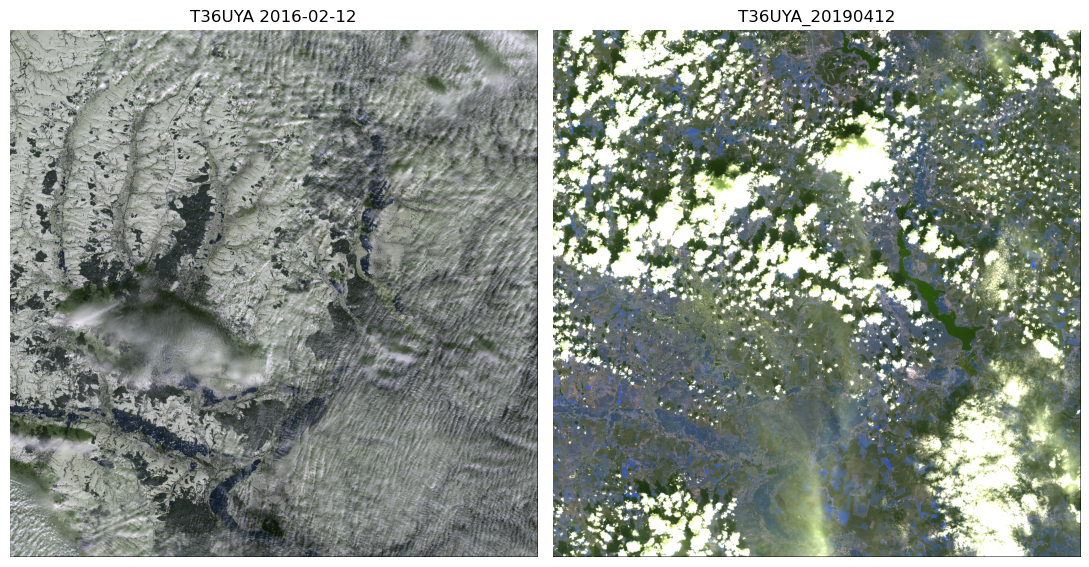

In [53]:
l1 = zoom(im1, (0.1, 0.1, 1), order=1)
l2 = zoom(im2, (0.1, 0.1, 1), order=1)


_, axes = plt.subplots(1, 2, figsize=(11, 24))
axes[0].imshow(l1)
axes[0].axis("off")
axes[0].set_title("T36UYA 2016-02-12")
axes[1].imshow(l2)
axes[1].axis("off")
axes[1].set_title("T36UYA_20190412")
plt.tight_layout()
plt.show()

We can observe that the choice of specific channels has resulted  
in vegetation appearing more prominently in the images.

## We will split the satellite images into smaller tiles.

The original resolution of the images is 10980×10980. To make them more  
manageable for processing, we will divide them into tiles with a resolution of 732×732.

In [ ]:
import os
import imageio

def divide_into_pieces(image_array, save_path, width, height):
    """
    Divide a 3D image array into smaller pieces and save them as individual PNG files.
    
    Parameters:
    image_array (numpy.ndarray): 3D array containing the image data.
    save_path (str): Path to the directory where the image pieces will be saved.
    width (int): Width of each image piece.
    height (int): Height of each image piece.
    """
    # Create the save directory if it doesn't exist
    if not os.path.exists(save_path):
        os.makedirs(save_path, exist_ok=True)
        os.makedirs(f'{save_path}/images', exist_ok=True)
        print('Data directory created.')
    
    full_height, full_width = image_array.shape[:2]
    for j in range(0, full_height // height):
        for i in range(0, full_width // width):
            # Extract a window of the image based on the current indices
            window = image_array[
                j * height:(j + 1) * height,
                i * width:(i + 1) * width,
                :3
            ]
            piece_name = f'piece_{j}_{i}.png'
            imageio.imwrite(f'{save_path}/{piece_name}', window)

In [6]:
divide_into_pieces(im1, save_path='im1', width=732, height=732)
divide_into_pieces(im2, save_path='im2', width=732, height=732)

Data directory created.
Data directory created.


# We will build the LoFTR model.
We will use this powerful model to find matching keypoint pairs  
for each image pair. To do this, we will also combine the three  
image channels into one.

In [ ]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from kornia.feature import LoFTR

def load_and_preprocess_image(image_path, target_size=(732, 732)):
    """
    Load and preprocess an image.
    
    Parameters:
    image_path (str): Path to the input image.
    target_size (tuple): Desired size of the output image (width, height).
    
    Returns:
    numpy.ndarray: Preprocessed image as a numpy array.
    """
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, target_size)
    image = image.astype(np.float32) / 255.0
    
    return image

def match_pieces(img1_path, img2_path):
    """
    Match keypoints between two images using the LoFTR model.
    
    Parameters:
    img1_path (str): Path to the first input image.
    img2_path (str): Path to the second input image.
    
    Returns:
    numpy.ndarray: First input image.
    numpy.ndarray: Second input image.
    numpy.ndarray: Keypoints from the first image.
    numpy.ndarray: Keypoints from the second image.
    numpy.ndarray: Confidence scores for the matches.
    """
    img1 = load_and_preprocess_image(img1_path)
    img2 = load_and_preprocess_image(img2_path)
    
    img1_tensor = torch.from_numpy(img1)[None][None]
    img2_tensor = torch.from_numpy(img2)[None][None]
    
    matcher = LoFTR(pretrained='outdoor')
    matcher.eval()
    
    with torch.no_grad():
        # Find the matches
        data = {'image0': img1_tensor, 'image1': img2_tensor}
        matches = matcher(data)
        
        # Extract the keypoint coordinates and confidence scores
        mkpts0 = matches['keypoints0']
        mkpts1 = matches['keypoints1']
        confidence = matches['confidence'].cpu().numpy()
    
    return img1, img2, mkpts0, mkpts1, confidence

def visualize_matches(img1, img2, mkpts0, mkpts1, confidence, conf_threshold=0.9, dtype=float):
    """
    Visualize the matched keypoints between two images with connecting lines.
    Works with both color and grayscale images.
    
    Parameters:
    img1 (numpy.ndarray): First input image.
    img2 (numpy.ndarray): Second input image.
    mkpts0 (numpy.ndarray): Keypoints from the first image.
    mkpts1 (numpy.ndarray): Keypoints from the second image.
    confidence (numpy.ndarray): Confidence scores for the matches.
    conf_threshold (float): Minimum confidence threshold for displaying matches.
    dtype (type): Data type for the output image.
    """
    # Filter the matches based on confidence threshold
    mask = confidence > conf_threshold
    mkpts0 = mkpts0[mask]
    mkpts1 = mkpts1[mask]
    confidence = confidence[mask]
    
    # Convert the images to 3-channel (RGB) if they are grayscale
    if len(img1.shape) == 2:  # Grayscale image
        img1_colored = np.stack([img1] * 3, axis=-1)
    else:  # Color image
        img1_colored = img1
    
    if len(img2.shape) == 2:  # Grayscale image
        img2_colored = np.stack([img2] * 3, axis=-1)
    else:  # Color image
        img2_colored = img2
    
    # Get the dimensions of the images
    h1, w1 = img1_colored.shape[:2]
    h2, w2 = img2_colored.shape[:2]
    
    # Create a canvas to place the two images side-by-side
    canvas = np.zeros((max(h1, h2), w1 + w2, 3), dtype=dtype)
    canvas[:h1, :w1, :] = img1_colored
    canvas[:h2, w1:w1+w2, :] = img2_colored
    
    fig, ax = plt.subplots(figsize=(13, 26))
    ax.imshow(canvas)
    
    # Draw the matches with connecting lines
    for (x1, y1), (x2, y2), conf in zip(mkpts0, mkpts1, confidence):
        color = plt.cm.viridis(conf)  # Color the line based on confidence
        x2_shifted = x2 + w1  # Shift the x-coordinate for the second image
        ax.plot([x1, x2_shifted], [y1, y2], color=color, linewidth=1)  # Draw the line
        ax.plot(x1, y1, 'o', color=color, markersize=7)  # Draw the point on the first image
        ax.plot(x2_shifted, y2, 'o', color=color, markersize=7)  # Draw the point on the second image
    
    ax.set_title(f'Matches visualized: {len(mkpts0)}')
    ax.axis('off')
    plt.tight_layout()

/home/pil00pa/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Total matches found: 640
Matches with confidence > 0.9: 99


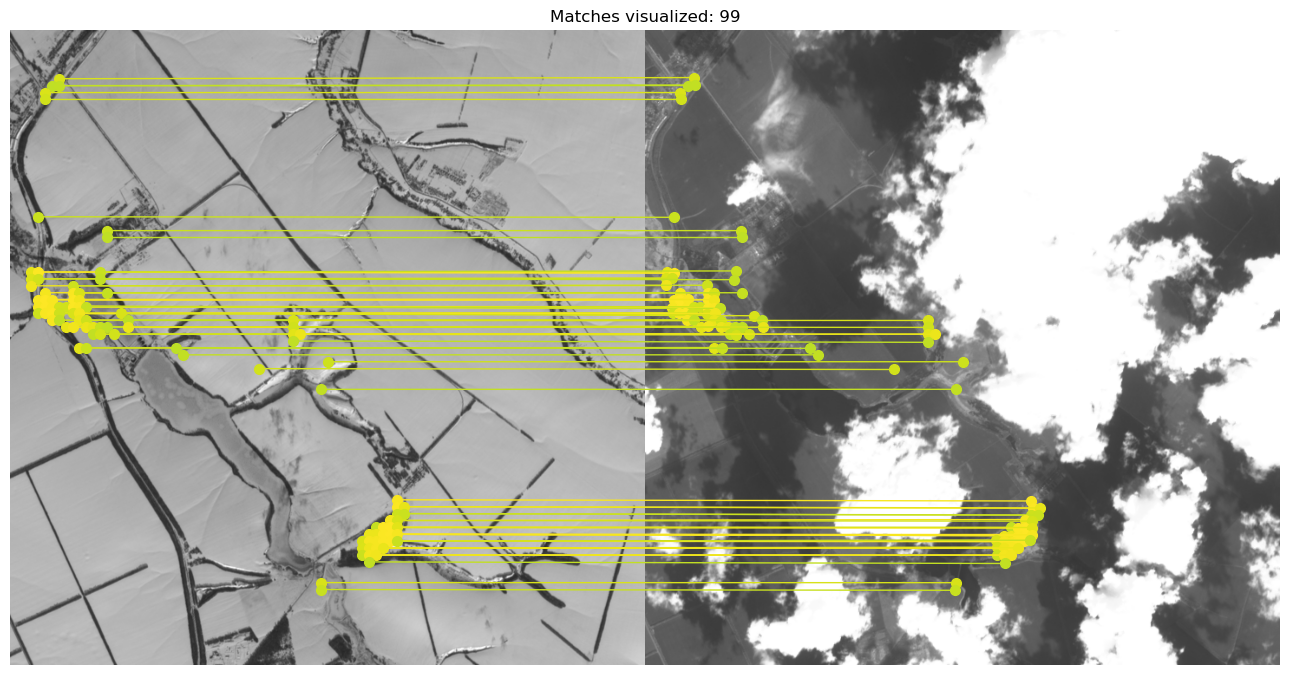

In [57]:
piece1_path = "im1/piece_0_0.png"
piece2_path = "im2/piece_0_0.png"

# Match the images
img1, img2, mkpts0, mkpts1, confidence = match_pieces(piece1_path, piece2_path)

# Print match statistics
total_matches = len(confidence)
high_confidence_matches = np.sum(confidence > 0.9)
print(f"Total matches found: {total_matches}")
print(f"Matches with confidence > 0.9: {high_confidence_matches}")

# Visualize the results
fig = visualize_matches(img1, img2, mkpts0, mkpts1, confidence)
plt.show()

1) We can see that the model has successfully identified keypoints, as  
evidenced by the horizontal lines (on each image, the corresponding pixels  
relate to roughly the same areas of the Earth's surface).
2) We will perform a similar analysis for all images and  
combine the results into one.

## Apply the model to the entire image.

In [ ]:
import re
import os
import rasterio
import numpy as np
import torch
from kornia.feature import LoFTR
import imageio

class ImageMatcher():
    def __init__(self, path1, path2, bands=["04", "03", "08"], target_size=(732, 732)):
        """
        Initialize the ImageMatcher class.
        
        Parameters:
        path1 (str): Path to the first image.
        path2 (str): Path to the second image.
        bands (list): List of band names to use for the images.
        target_size (tuple): Desired size of the images after preprocessing.
        """
        self.path1 = path1
        self.path2 = path2
        self.bands = bands
        self.target_size = target_size
        self.matcher = LoFTR(pretrained='outdoor')
        self.matcher.eval()

    def _imread_3bands(self, path, bands):
        """
        Load and preprocess a 3-band satellite image.
        
        Parameters:
        path (str): Base path to the image files.
        bands (list): List of band names to load.
        
        Returns:
        numpy.ndarray: 3D array containing the preprocessed image.
        """
        channels = []
        for band in bands:
            with rasterio.open(f'{path}{band}.jp2', "r", driver="JP2OpenJPEG") as src:
                channel = src.read(1).astype(float)
                q1 = np.percentile(channel, 25)
                q3 = np.percentile(channel, 75)
                iqr = q3 - q1
                channel /= q3 + 1.5 * iqr
                channel_8bit = (np.clip(channel, 0, 1) * 255).astype(np.uint8)
                channels.append(channel_8bit)
        return np.stack(channels, axis=-1)

    def _divide_into_pieces(self, image_array, save_path, width, height):
        """
        Divide a 3D image array into smaller pieces and save them as individual PNG files.
        
        Parameters:
        image_array (numpy.ndarray): 3D array containing the image data.
        save_path (str): Path to the directory where the image pieces will be saved.
        width (int): Width of each image piece.
        height (int): Height of each image piece.
        """
        if not os.path.exists(save_path):
            os.makedirs(save_path, exist_ok=True)
            os.makedirs(f'{save_path}/images', exist_ok=True)
            print('Data directory created.')

        full_height, full_width = image_array.shape[:2]
        for j in range(0, full_height // height):
            for i in range(0, full_width // width):
                window = image_array[
                    j * height:(j + 1) * height,
                    i * width:(i + 1) * width,
                    :3
                ]
                piece_name = f'piece_{j}_{i}.png'
                imageio.imwrite(f'{save_path}/{piece_name}', window)

    def _load_and_preprocess_image(self, image_path):
        """
        Load and preprocess a single image.
        
        Parameters:
        image_path (str): Path to the input image.
        
        Returns:
        numpy.ndarray: Preprocessed image as a numpy array.
        """
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, self.target_size)
        image = image.astype(np.float32) / 255.0
        
        return image

    def _match_pieces(self, piece1_path, piece2_path):
        """
        Match keypoints between two image pieces using the LoFTR model.
        
        Parameters:
        piece1_path (str): Path to the first image piece.
        piece2_path (str): Path to the second image piece.
        
        Returns:
        numpy.ndarray: First image piece.
        numpy.ndarray: Second image piece.
        numpy.ndarray: Keypoints from the first image piece.
        numpy.ndarray: Keypoints from the second image piece.
        numpy.ndarray: Confidence scores for the matches.
        """
        img1 = self._load_and_preprocess_image(piece1_path)
        img2 = self._load_and_preprocess_image(piece2_path)
        
        img1_tensor = torch.from_numpy(img1)[None][None]
        img2_tensor = torch.from_numpy(img2)[None][None]
        
        with torch.no_grad():
            data = {'image0': img1_tensor, 'image1': img2_tensor}
            matches = self.matcher(data)
    
            mkpts0 = matches['keypoints0'].cpu().numpy()
            mkpts1 = matches['keypoints1'].cpu().numpy()
            confidence = matches['confidence'].cpu().numpy()
            
        return img1, img2, mkpts0, mkpts1, confidence
    
    def get_matching(self):
        """
        Perform image matching between the two input images.
        
        Returns:
        dict: A dictionary mapping image piece coordinates to the matching results.
        """
        # Load and preprocess the full-size images
        im1 = self._imread_3bands(self.path1, self.bands)
        im2 = self._imread_3bands(self.path2, self.bands)
        
        # Determine the names of the image piece directories
        piece1_path = self.path1.split('/')[-3]
        piece2_path = self.path2.split('/')[-3]
        
        # Divide the full-size images into smaller pieces
        self._divide_into_pieces(im1, piece1_path, *self.target_size)
        self._divide_into_pieces(im2, piece2_path, *self.target_size)
        
        # Find the paths of the individual image pieces
        pattern = re.compile(r'_(\d+)_(\d+)\.png$')
        def get_pieces(dir):
            pieces = {}
            for filename in os.listdir(dir):
                match = pattern.search(filename)
                if match:
                    i = int(match.group(1))
                    j = int(match.group(2))
                    pieces[(i, j)] = dir+'/'+filename    
            return pieces
        
        pieces1 = get_pieces(piece1_path)
        pieces2 = get_pieces(piece2_path)
        
        # Match the corresponding image pieces
        pieces_matchings = {}
        for p in pieces1:
            pieces_matchings[p] = self._match_pieces(pieces1[p], pieces2[p])
            print(pieces1[p].split('/')[-1], " is analyzed.")
        return pieces_matchings

In [ ]:
image_matcher = ImageMatcher(im1_path, im2_path)
results = image_matcher.get_matching()
np.save('results.npy', results)

piece_5_5.png  is analyzed.
piece_4_4.png  is analyzed.
piece_2_10.png  is analyzed.
piece_10_11.png  is analyzed.
piece_6_9.png  is analyzed.
piece_4_14.png  is analyzed.
piece_0_12.png  is analyzed.
piece_1_7.png  is analyzed.
piece_2_2.png  is analyzed.
piece_14_9.png  is analyzed.
piece_0_3.png  is analyzed.
piece_13_8.png  is analyzed.
piece_14_13.png  is analyzed.
piece_14_14.png  is analyzed.
piece_8_14.png  is analyzed.
piece_11_9.png  is analyzed.
piece_10_14.png  is analyzed.
piece_8_3.png  is analyzed.
piece_7_10.png  is analyzed.
piece_7_8.png  is analyzed.
piece_1_6.png  is analyzed.
piece_5_2.png  is analyzed.
piece_7_13.png  is analyzed.
piece_2_7.png  is analyzed.
piece_11_7.png  is analyzed.
piece_13_13.png  is analyzed.
piece_4_10.png  is analyzed.
piece_12_14.png  is analyzed.
piece_0_13.png  is analyzed.
piece_13_0.png  is analyzed.
piece_2_5.png  is analyzed.
piece_6_6.png  is analyzed.
piece_0_14.png  is analyzed.
piece_11_11.png  is analyzed.
piece_10_10.png  is 

1) The data has been obtained, and now I will filter the matching  
results by comparing the pixel coordinates of the corresponding points.  
Although the data has only gone through the L1C processing stage, two  
points that correspond to the same physical location should not differ  
by more than 5 pixels (50 meters).

2) We will use a confidence threshold of 90%, as even with this level,  
we have obtained a large number of matches.

In [58]:
import numpy as np
import matplotlib.pyplot as plt

# Load precomputed matching results
results = np.load('results.npy', allow_pickle=True).item()

def prepare_matching(matches_dict, conf_threshold=0.9, target_height=10980, target_width=10980):
    """
    Prepare the matching results for visualization.
    
    Parameters:
    matches_dict (dict): Dictionary containing matching results for each image piece.
    conf_threshold (float): Minimum confidence threshold for including a match.
    target_height (int): Target height of the full-size images.
    target_width (int): Target width of the full-size images.
    
    Returns:
    list: A list containing:
         - numpy.ndarray: Keypoints from the first image.
         - numpy.ndarray: Keypoints from the second image.
         - numpy.ndarray: Confidence scores for the matches.
    """
    # Get the first matching result to determine image sizes
    img1, img2, mkpts0, mkpts1, confidence = list(matches_dict.values())[0]
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    
    prep_matchings = {}
    
    # Iterate over each image piece and process the matches
    for key, (_, _, mkpts0, mkpts1, confidence) in matches_dict.items():
        y_offset, x_offset = key
        
        # Filter matches by confidence threshold and the distance between points
        mask = (confidence > conf_threshold) & (np.linalg.norm(mkpts0 - mkpts1, axis=1) <= 5)
        mkpts0 = mkpts0[mask]
        mkpts1 = mkpts1[mask]
        confidence = confidence[mask]
        
        # Shift keypoint coordinates to match their position in the full-size image
        mkpts0[:, 0] += x_offset * w1  # Shift x-coordinates for the first image
        mkpts0[:, 1] += y_offset * h1  # Shift y-coordinates for the first image
        mkpts1[:, 0] += x_offset * w2  # Shift x-coordinates for the second image
        mkpts1[:, 1] += y_offset * h2  # Shift y-coordinates for the second image
        
        prep_matchings[key] = [mkpts0, mkpts1, confidence]
    
    mkpts0_all = []
    mkpts1_all = []
    confidence_all = []
    
    for mkpts0, mkpts1, conf in prep_matchings.values():
        mkpts0_all.extend(mkpts0)
        mkpts1_all.extend(mkpts1)
        confidence_all.extend(conf)
    
    mkpts0_all = np.array(mkpts0_all)
    mkpts1_all = np.array(mkpts1_all)
    confidence_all = np.array(confidence_all)
    
    return [mkpts0_all, mkpts1_all, confidence_all]

good_matchings = prepare_matching(results)
print("Number of matches:", len(good_matchings[0]))

Number of matches: 51472


We have obtained all the necessary results. Now, we will display  
the image in the standard RGB spectrum and mark 100 corresponding  
keypoints.

In [55]:
some_matchings = []
choice = np.random.choice(len(good_matchings[0]), size=100, replace=False)
for data in good_matchings:
    some_matchings.append(data[choice])


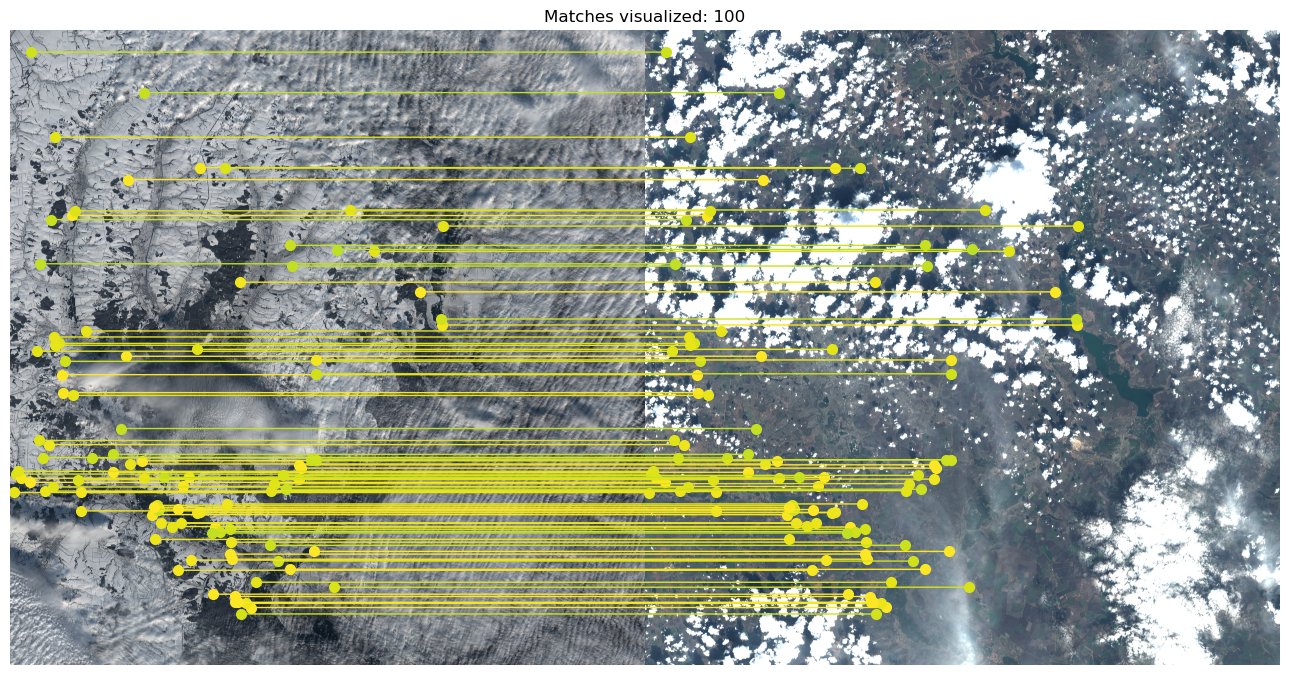

In [ ]:
im1_rgb = imread_3bands(path=im1_path, bands=["04", "03", "02"])
im2_rgb = imread_3bands(path=im2_path, bands=["04", "03", "02"])

visualize_matches(im1_rgb, im2_rgb, some_matchings[0], some_matchings[1], some_matchings[2], dtype=np.uint8)

It is immediately apparent that the clouds prevented our model from  
finding matching keypoints, especially in the lower-left corner. This  
is most noticeable because, on the first image, there are thick clouds  
in that area, making it difficult for the model to detect corresponding  
points.

In [1]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
